In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/RNN Masters/Recurrent Neural Networks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/RNN Masters/Recurrent Neural Networks


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-bright')

import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm

import tasks
import models
import model_parameters

In [3]:
#Alpha
parameters = model_parameters.alpha_parameters
task = tasks.TICT(parameters["alpha"])
task.create_trials()
model = models.RNN_Alfa(task.n_inputs, parameters["hidden_size"], task.n_outputs,
                 task.alpha, parameters["diag"], parameters["sigma_rec"])


In [8]:
%cd saved_models/
model.load_state_dict(torch.load(parameters["model_name"]))
%cd ..

n_check = 30
n_epochs = 200 * 5 + 1
d1_max = 90
d2_max = 95
batch_size = parameters["batch_size"]
learning_rate = parameters["learning_rate"]
hidden_size = parameters["hidden_size"]

/content/drive/MyDrive/Colab Notebooks/RNN Masters/Recurrent Neural Networks/saved_models
/content/drive/MyDrive/Colab Notebooks/RNN Masters/Recurrent Neural Networks


<ipython-input-8-3d1901fc706e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(parameters["model_name"]))


## Warm up


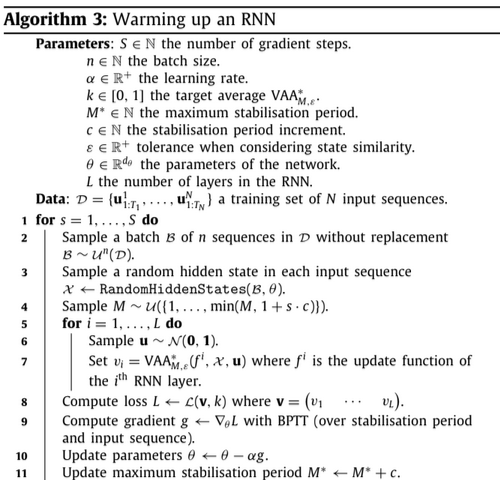

In [ ]:
def VAA_star(hn, epsilon):
  """
  Returns the truncated VAA* as described in the paper, for the set of hidden
  states `hn` and a tolerance of `epsilon`.
  """
  n = hn.size(0)
  vaa = torch.tensor(0.0, device=hn.device)
  tanh = torch.tanh(hn)
  epsilon_inverse = 1e-6

  for i in range(n):
    dist_i = torch.norm(tanh[:, :] - tanh[i, :], dim=1)
    Ci = 1.0 - F.relu(dist_i - epsilon) / (dist_i + epsilon_inverse)
    vaa = vaa + (1.0 / Ci.sum()) * (1.0 / n)
  return vaa


def warm_up(model):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  c = 10
  M_star = 200
  k = torch.tensor(0.95)
  epsilon = 1e-3

  n_epochs_warmup = 100
  n_hidden_states = 32
  n_batch = int(n_hidden_states / 2)
  for s in tqdm(range(n_epochs_warmup)):
    inputs, labels, starts, ends, _, _  = task.get_random_trials(batch_size)
    data, targets = task.get_data(inputs, labels)
    loss = 0

    # Sample X
    sampled_states = torch.zeros((n_hidden_states, parameters["hidden_size"]))
    for b in range(n_batch):
      _, hidden = model(data, ends, b)
      t = np.random.randint(ends[0, b], size = 2)
      sampled_states[b, :] = hidden[0, t[0], :]
      sampled_states[b + n_batch, :] = hidden[0, t[1], :]

    # Sample M
    M = np.random.choice(np.arange(1, min(M_star, 2 + s * c)))

    # Get VAA*
    f_M = torch.zeros(sampled_states.shape)
    for n in range(n_hidden_states):
      f_M[n, :] = model.simulate(sampled_states[n, :], M)

    v = VAA_star(f_M, epsilon)

    # Loss and gradient step
    loss = criterion(v, k)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model_name = "Alpha_TICT_warmup2.txt"

In [ ]:
warm_up(model)

100%|██████████| 100/100 [07:40<00:00,  4.60s/it]


## Training

In [6]:
def check_produced(scores, T5s, b, ti):
  no_early_response = torch.max(scores[b, :int(T5s[b]), :]) < 0.2
  only_one_up = ((torch.max(scores[b, ti:ti+15, 0]) > 0.5 and
                  torch.max(scores[b, ti:ti+15, 1]) < 0.5) or
                  (torch.max(scores[b, ti:ti+15, 0]) < 0.5 and
                  torch.max(scores[b, ti:ti+15, 1]) > 0.5))
  return no_early_response and only_one_up

def check_accuracy(model):
  num_correct1 = 0
  num_correct2 = 0
  num_samples = 0

  model.eval()

  with torch.no_grad():
    for i in range(int(n_check / 5)):
      inputs, labels, starts, ends, Ts, obj = task.get_random_trials(batch_size)
      T5s = Ts[4, :]
      data, targets = task.get_data(inputs, labels)

      scores = torch.zeros(targets.shape)
      # forward
      for b in range(batch_size):
        scores1, _ = model(data, ends, b)
        scores1[0, :int(starts[0, b] - 1), :] *= 0
        scores[b, :int(ends[0, b]) , :] = scores1

      for b in range(batch_size):
        num_samples += 1
        ti = np.argmax(labels[b, :, int(obj[0,b])] > 0.5)

        if check_produced(scores, T5s, b, ti):
          num_correct1 += 1
          if torch.max(scores[b, ti:ti+15, int(obj[0, b])]) > 0.5:
            num_correct2 += 1

  model.train()
  try:
    return num_correct1/num_samples*100, num_correct2/num_correct1*100
  except:
    return num_correct1/num_samples*100, 0

def train(model, save = False):
  criterion = nn.MSELoss(reduction="sum")
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  loss_list = np.array([])
  produced_int = np.array([])
  correct_decision = np.array([])
  min_loss = 1e5

  for i in tqdm(range(1, n_epochs)):
    if i%n_check == 0:
      loss_list = np.append(loss_list, loss.detach().numpy())
      d1, d2 = check_accuracy(model)
      produced_int = np.append(produced_int, d1)
      correct_decision = np.append(correct_decision, d2)
      print(f" loss: {int(loss)} produced intervals: {d1:.2f}%; " \
            f"correct decisions: {d2:.2f}%")
      if save and int(loss) < min_loss:
        min_loss = int(loss)
        torch.save(model.state_dict(), model_name)
      if d1 > d1_max and d2 > d2_max:
        print("success")
        break

    inputs, labels, starts, ends, _, _  = task.get_random_trials(batch_size)
    data, targets = task.get_data(inputs, labels)
    loss = 0

    # forward
    for b in range(batch_size):
      scores, _ = model(data, ends, b)
      scores[0, :int(starts[0, b] - 1), :] *= 0
      loss += criterion(scores[0, :, :], targets[b, :int(ends[0, b]), :])

    # backward
    optimizer.zero_grad()
    loss.backward()

    # gradient descent update step
    optimizer.step()

  return loss_list, produced_int, correct_decision

loss_list, produced_int, correct_decision = train(model, save=False)

  0%|          | 2/1000 [00:29<4:00:08, 14.44s/it]

 loss: 41470 produced intervals: 0.00%; correct decisions: 0.00%


  0%|          | 2/1000 [00:59<8:17:59, 29.94s/it]


KeyboardInterrupt: 

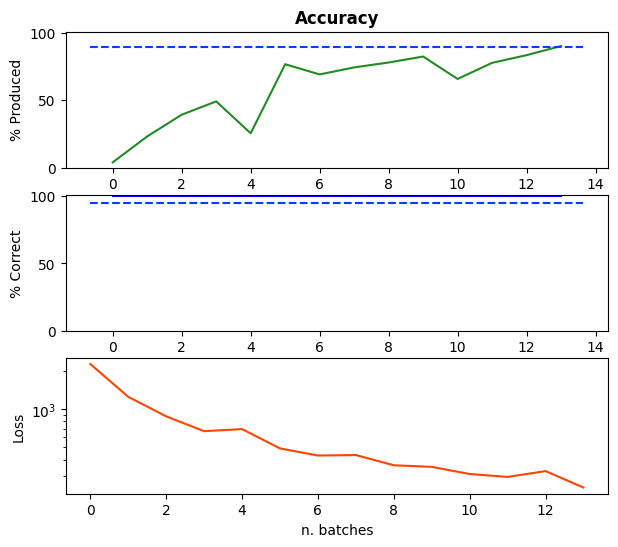

In [ ]:
plt.figure(figsize=(7,6))

plt.subplot(311)
plt.title("Accuracy", weight="bold")
plt.plot(produced_int, color="forestgreen")
axes = plt.gca()
xi, xs = axes.get_xlim()
plt.hlines(d1_max, xi, xs, linestyles="dashed")
plt.ylabel("% Produced")
plt.ylim([0, 101])

plt.subplot(312)
plt.plot(correct_decision, color="blue")
plt.hlines(d2_max, xi, xs, linestyles="dashed")
plt.ylim([0, 101])
plt.ylabel("% Correct")

plt.subplot(313)
plt.plot(loss_list, color="orangered")
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("n. batches")
plt.show()

## Testing

In [10]:
inputs, labels, starts, ends, Ts, obj = task.get_random_trials(batch_size)
T2s = Ts[1, :]
T3s = Ts[2, :]
data, targets = task.get_data(inputs, labels)

with torch.no_grad():
  scores = torch.zeros(targets.shape)
  hidden = torch.zeros(batch_size, task.lentv, hidden_size)
  for b in range(batch_size):
    scores1, hidden1 = model(data, ends, b)
    hidden[b, :, :] = hidden1
    scores1[0, :int(starts[0, b] - 1), :] *= 0
    scores[b, :int(ends[0, b]), :] = scores1

n = 1

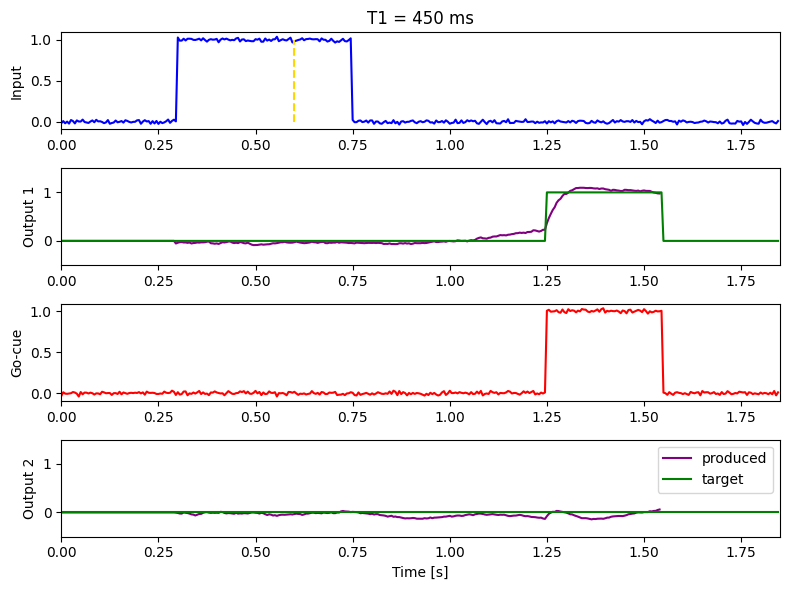

In [ ]:
def plot_trial(n, title, xlims = [0, task.t_final]):
  test_trial = scores[n, :int(ends[0, n]) - 1, :].detach().numpy()
  ylims = [-0.5,1.5]

  plt.figure(figsize=(8,6))

  plt.subplot(411)
  plt.title(title)
  plt.plot(task.tv, inputs[n, :, 0],color="blue")
  mid_indx = starts[0, n] + task.time2indx(task.mid_T)
  plt.vlines(tv[mid_indx], 0, 1, linestyle="--", color="gold")
  plt.xlim(xlims)
  plt.ylabel("Input")

  plt.subplot(412)
  plt.plot(tv[:int(ends[0, n]) - 1], test_trial[:, 0], color="purple")
  plt.plot(tv, labels[n, :, 0], color="green")
  plt.ylim(ylims)
  plt.ylabel("Output 1")
  plt.xlim(xlims)

  plt.subplot(413)
  plt.plot(tv, inputs[n, :, 1], color="red")
  plt.xlim(xlims)
  plt.ylabel("Go-cue")

  plt.subplot(414)
  plt.plot(tv[:int(ends[0, n]) - 1], test_trial[:, 1], color="purple")
  plt.plot(tv, labels[n, :, 1], color="green")
  plt.xlabel("Time [s]")
  plt.ylabel("Output >")
  plt.ylim(ylims)
  plt.legend(["produced", "target"])
  plt.xlim(xlims)
  plt.ylabel("Output 2")

  plt.tight_layout()
  plt.show()

n += 1
title = "T1 = " + str(int(T2s[n] * step * 1e3)) + " ms"
plot_trial(n, title)